### 4.10.1 下载和缓存数据集
在整本书中，我们将下载不同的数据集，并训练和测试模型。 这里我们实现几个函数来方便下载数据。 首先，我们建立字典DATA_HUB， 它可以将数据集名称的字符串映射到数据集相关的二元组上， 这个二元组包含数据集的url和验证文件完整性的sha-1密钥。 所有类似的数据集都托管在地址为DATA_URL的站点上。

In [1]:
import hashlib
import os
import tarfile
import zipfile
import  requests

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

下面的download函数用来下载数据集， 将数据集缓存在本地目录（默认情况下为../data）中， 并返回下载文件的名称。 如果缓存目录中已经存在此数据集文件，并且其sha-1与存储在DATA_HUB中的相匹配， 我们将使用缓存的文件，以避免重复的下载。

In [2]:
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

我们还需实现两个实用函数： 一个将下载并解压缩一个zip或tar文件， 另一个是将本书中使用的所有数据集从DATA_HUB下载到缓存目录中。

In [3]:
def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

#### 4.10.3 访问和读取数据集
注意，竞赛数据分为训练集和测试集。 每条记录都包括房屋的属性值和属性，如街道类型、施工年份、屋顶类型、地下室状况等。 这些特征由各种数据类型组成。 例如，建筑年份由整数表示，屋顶类型由离散类别表示，其他特征由浮点数表示。 这就是现实让事情变得复杂的地方：例如，一些数据完全丢失了，缺失值被简单地标记为“NA”。 每套房子的价格只出现在训练集中（毕竟这是一场比赛）。 我们将希望划分训练集以创建验证集，但是在将预测结果上传到Kaggle之后， 我们只能在官方测试集中评估我们的模型。

In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [5]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [6]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [7]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [8]:
# 让我们看看前四个和最后两个特征，以及相应标签（房价）。
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


我们可以看到，在每个样本中，第一个特征是ID， 这有助于模型识别每个训练样本。 虽然这很方便，但它不携带任何用于预测的信息。 因此，在将数据提供给模型之前，我们将其从数据集中删除。

In [9]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

#### 4.10.4 数据预处理
 首先，我们将所有缺失的值替换为相应特征的平均值。
 然后，为了将所有特征放在一个共同的尺度上， 我们通过将特征重新缩放到零均值和单位方差来标准化数据：
 ![数据预处理](imgs/4_10_4数据预处理1.png)
 其中 μ 和 σ 分别表示均值和标准差。 现在，这些特征具有零均值和单位方差
  直观地说，我们标准化数据有两个原因： 首先，它方便优化。 其次，因为我们不知道哪些特征是相关的， 所以我们不想让惩罚分配给一个特征的系数比分配给其他任何特征的系数更大。

In [10]:
# 若无法获得测试数据，则可根据训练数据计算均值和标准差
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std())
)
# 在标准化后，所有的均值消失，因此我们可以把缺失值设为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [11]:
numeric_features

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [12]:
# 处理离散值，利用onehot
all_features

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,0.067320,RL,-0.184443,-0.217841,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-1.551918,0.157619,WD,Normal
1,-0.873466,RL,0.458096,-0.072032,Pave,NaN,Reg,Lvl,AllPub,FR2,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-0.446848,-0.602858,WD,Normal
2,0.067320,RL,-0.055935,0.137173,Pave,NaN,IR1,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,1.026577,0.157619,WD,Normal
3,0.302516,RL,-0.398622,-0.078371,Pave,NaN,IR1,Lvl,AllPub,Corner,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-1.551918,-1.363335,WD,Abnorml
4,0.067320,RL,0.629439,0.518814,Pave,NaN,IR1,Lvl,AllPub,FR2,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,2.131647,0.157619,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2.419286,RM,-2.069222,-1.043758,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-0.078492,-1.363335,WD,Normal
1455,2.419286,RM,-2.069222,-1.049083,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-0.815205,-1.363335,WD,Abnorml
1456,-0.873466,RL,3.884968,1.246594,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,1.026577,-1.363335,WD,Abnorml
1457,0.655311,RL,-0.312950,0.034599,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,MnPrv,Shed,1.144116,0.289865,-1.363335,WD,Normal


In [13]:
# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [14]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1,1), dtype=torch.float32
)

#### 4.10.5 训练
首先，我们训练一个损失平方的线性模型。显然线性模型很难让我们在比赛中获胜，但是线性模型提供了一种健全性检查，以查看数据中是否存在有意义的信息。
如果我们在这里不能做到比随即猜测更好，那么我们很可能存在数据处理错误。
如果一切顺利，线性模型将作为baseline，让我们直观地知道最好的模型超出简单的模型多少。

In [15]:
loss = nn.MSELoss() # 使用默认设置(输出的loss为标量形式，并且是平均值)：
in_features = train_features.shape[1]
def get_net():
    net = nn.Sequential(nn.Linear(in_features, 1))
    return net

房价就像股票价格一样，我们关心的是相对数量，而不是绝对数量。
因此，我们更关心相对误差 (y−y\^)/y ， 而不是绝对误差 y−y\^ 。

>  例如，如果我们在俄亥俄州农村地区估计一栋房子的价格时， 假设我们的预测偏差了10万美元， 然而那里一栋典型的房子的价值是12.5万美元， 那么模型可能做得很糟糕。 另一方面，如果我们在加州豪宅区的预测出现同样的10万美元的偏差， （在那里，房价中位数超过400万美元） 这可能是一个不错的预测。

##### 解决这个问题的一种方法是用价格预测的对数来衡量差异
![对数均方根误差](imgs/4_10_5训练1.png)

In [16]:
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clippd_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clippd_preds), torch.log(labels)))
    return rmse.item()

![MSE](imgs/4_10_5训练2.png)

In [17]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate,weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

#### 4.10.6 K 折交叉验证
当训练数据稀缺时，我们甚至可能无法提供足够的数据来构成一个合适的验证集。 这个问题的一个流行的解决方案是采用\(K\)折交叉验证。 这里，原始训练数据被分成\(K\)个不重叠的子集。 然后执行\(K\)次模型训练和验证，每次在\(K-1\)个子集上进行训练， 并在剩余的一个子集（在该轮中没有用于训练的子集）上进行验证。 最后，通过对\(K\)次实验的结果取平均来估计训练和验证误差。

In [28]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

#### 4.10.8 提交你的Kaggle预测


In [45]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

训练log rmse：0.162478


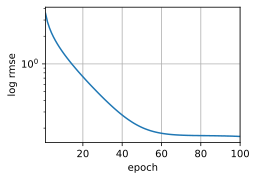

In [46]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)